# Recurrent neural network: IMDB example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import plot_model
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import SimpleRNN, Embedding, Input
from keras.layers.recurrent import LSTM, GRU
from typing import List

from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
# For reproducibility:
np.random.seed(1234)

from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
import os

img_path = './img'

if not os.path.isdir(img_path):
    os.mkdir(img_path)

## Global parameters and helper functions

In [4]:
# Vector space embedding:
embedding_dim = 64
n_top_freq_words = 10000
max_review_length = 100
# drop_embed = 0.2

# Training:
epochs = 16
batch_size = 128

# RNN layer architecture:
#n_rnn = 256
#drop_rnn = 0.2

In [5]:
def train_and_eval(model, input_train, y_train, input_test, y_test):
    model.fit(input_train,  
              y_train,
              epochs=4,
              batch_size=batch_size,
              validation_split=0.2)
    
    score, acc = model.evaluate(input_test, y_test)
    
    print('Test score:', score)
    print('Test accuracy:', acc)

In [6]:
def display_model(model):
    from IPython.display import Image
    from IPython.core.display import HTML 
    
    path = './img/{}.png'.format(model.name)
    plot_model(model, to_file=path)
    
    return Image(url=path)

In [7]:
def display_class_seperation(model):
    y_test_preds = model.predict_proba(input_test)

    plt.hist(y_test_preds)
    plt.xlim(0, 1)
    _ = plt.axvline(x=0.5, color='red')

    "AUC: {:0.2f}".format(roc_auc_score(y_test, y_test_preds) * 100.0)

## The data

The data set consist of reviews for movies from IMDB, the Internet Movie Database. It contains reviews for 25,000 movies, each labeled by sentiment (positive/negative). Sentiment is encoded as `1` if positive and as `0` otherwise.

Fortunately the data has already been preprocessed: each review is encoded as a sequence of word indexes (integers). The word index itself is the position of a word in the list of all unique words contained in all 25,000 movies ordered by their frequency (from most frequent words down to the most uncommon ones). So the word index "3" encodes the 3rd most frequent word in the data, which happens to be "a" like in "a movie".

By convention, "0" does not stand for a specific word. Instead it is used to encode any unknown word and can be used for padding (see below).

Here are some example reviews from IMDB:

We load the data set and split it intro training and test sets. Notice than we only pick the top `num_words=500` words (by frequency).

In [8]:
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=n_top_freq_words, 
                                                              index_from=0)

Let's get an overview on how big the sets are. As it turns out the data is split in 50% for training and 50% for test. (Note: We cannot specify `test_split` for this data set in the `load_data` function.) As promised there are two labels.

In [9]:
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Shape train sequences:', input_train.shape)
print('Shape test sequences:', input_test.shape)
print('Shape train labels:', y_train.shape)
print('Shape test labels:', y_test.shape)
print('Number of classes:', len(np.unique(y_test)))

25000 train sequences
25000 test sequences
Shape train sequences: (25000,)
Shape test sequences: (25000,)
Shape train labels: (25000,)
Shape test labels: (25000,)
Number of classes: 2


We can use Pandas to have a look at the first training samples. As said each of them is a list of word indexes.

In [10]:
pd.DataFrame(input_train, columns=["word_index_sequence"]).head()

,word_index_sequence
0,"[1, 11, 19, 13, 40, 527, 970, 1619, 1382, 62, ..."
1,"[1, 191, 1150, 191, 8252, 75, 225, 2, 3, 1460,..."
2,"[1, 11, 44, 5, 27, 28, 4, 1, 246, 105, 4, 1, 5..."
3,"[1, 1, 2, 2, 30, 2801, 1, 2037, 429, 108, 150,..."
4,"[1, 246, 1320, 4, 58, 110, 7, 7, 10, 1634, 11,..."


The following functions loads the word index of the IMDB data set and allows us to translate a word index vector to a human readable format.

In [11]:
def decode(word_indizes: List[int]):
    word_index = imdb.get_word_index()
    
    inverse_word_index = {
        index:word 
        for word, index 
        in word_index.items()
    }
    
    words = [
        inverse_word_index.get(wrd_idx, '<missing-word>') 
        for wrd_idx 
        in word_indizes
    ]
    
    review_txt = ' '.join(words)
    
    return review_txt

The obvious counter part for encoding a review as a word index vector:

In [12]:
def encode(review: str):
    word_index = imdb.get_word_index()
    
    encoded_review = [
        word_index.get(word, 0) 
        for word 
        in review.lower().split(" ")
    ]
    
    return encoded_review

Let's check everythings works fine by encoding and decoding an example:

In [13]:
review = "Even those from the era should be turned off."
print(decode(encode(review))) 

'even those from the era should be turned <missing-word>'

Here is a real training example. (Note: Some words are clearly missing. Remember we limited ourself to the `num_words = 500` when loading the data via `imdb.load_data` above.) The review was favorable and thus gets a sentiment score of 1.

In [14]:
print('Review: "{}"\n'.format(decode(input_train[10])))
print('Sentiment: ', y_train[10])

Review: "the french horror cinema has seen something of a revival over the last couple of years with great films such as inside and and romance and on to the scene and and the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made and was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is and by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named and sent to prison for fraud he is put in a cell with three others the quietly insane and body building and marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old and after and part of it they soon realise its magical powers and realise they may be able to use it to break through 

## Preprocessing: Padding

In [15]:
input_train = sequence.pad_sequences(input_train, maxlen=max_review_length)
input_test = sequence.pad_sequences(input_test, maxlen=max_review_length)

In [16]:
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

input_train shape: (25000, 100)
input_test shape: (25000, 100)


In [17]:
input_train[0]

array([1412,   30,    3,   19,    9,  212,   25,   74,   49,    2,   11,
        404,   13,   79,    2,    5,    1,  104,  114, 5949,   12,  253,
          1,    2,    4, 3763,    2,  720,   33,   68,   40,  527,  473,
         23,  397,  314,   43,    4,    1,    2, 1026,   10,  101,   85,
          1,  378,   12,  294,   95,   29, 2068,   53,   23,  138,    3,
        191, 7483,   15,    1,  223,   19,   18,  131,  473,   23,  477,
          2,  141,   27, 5532,   15,   48,   33,   25,  221,   89,   22,
        101,    1,  223,   62,   13,   35, 1331,   85,    9,   13,  280,
          2,   13, 4469,  110,  100,   29,   12,   13, 5342,   16,  175,
         29], dtype=int32)

## Simple RNN using the Sequential API

In [25]:
model = Sequential(name="simple_rnn_sequential")
model.add(Embedding(n_top_freq_words, 
                    embedding_dim, 
                    input_length=max_review_length, 
                    name="embedding_layer")) 
model.add(SimpleRNN(units=embedding_dim, name="simple_rnn_layer"))
model.add(Dense(1, activation='sigmoid', name="dense_layer"))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 64)          640000    
_________________________________________________________________
simple_rnn_layer (SimpleRNN) (None, 64)                8256      
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


In [26]:
display_model(model)

In [27]:
train_and_eval(model, input_train, y_train, input_test, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 10s 493us/step - loss: 0.6324 - acc: 0.6164 - val_loss: 0.4640 - val_acc: 0.7828
Epoch 2/4
20000/20000 [==============================] - 9s 473us/step - loss: 0.3411 - acc: 0.8564 - val_loss: 0.4035 - val_acc: 0.8236
Epoch 3/4
20000/20000 [==============================] - 9s 471us/step - loss: 0.1885 - acc: 0.9304 - val_loss: 0.5190 - val_acc: 0.7738
Epoch 4/4
25000/25000 [==============================] - 6s 254us/step
Test score: 0.6038453269004822
Test accuracy: 0.77156


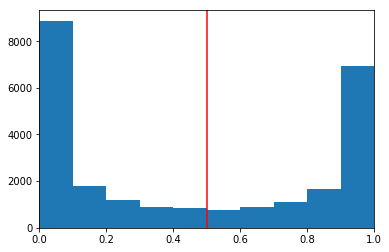

In [28]:
display_class_seperation(model)

## Simple RNN using the Functional API

In [29]:
inputs = Input(shape=(max_review_length,), name="input_layer")
embedding_layer = Embedding(n_top_freq_words, embedding_dim, name="embedding_layer")(inputs)
simple_rnn_layer = SimpleRNN(units=embedding_dim, name="simple_rnn_layer")(embedding_layer)
predictions = Dense(1, activation='sigmoid', name="dense_layer")(simple_rnn_layer)

model = Model(inputs=inputs, 
              outputs=predictions,
              name="simple_rnn_functional")

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 100, 64)           640000    
_________________________________________________________________
simple_rnn_layer (SimpleRNN) (None, 64)                8256      
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


In [30]:
display_model(model)

In [31]:
train_and_eval(model, input_train, y_train, input_test, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 10s 499us/step - loss: 0.6366 - acc: 0.6162 - val_loss: 0.4739 - val_acc: 0.7782
Epoch 2/4
20000/20000 [==============================] - 10s 480us/step - loss: 0.3467 - acc: 0.8522 - val_loss: 0.4106 - val_acc: 0.8294
Epoch 3/4
20000/20000 [==============================] - 10s 476us/step - loss: 0.1680 - acc: 0.9408 - val_loss: 0.5022 - val_acc: 0.7948
Epoch 4/4
25000/25000 [==============================] - 7s 261us/step
Test score: 0.5975196409416199
Test accuracy: 0.79024


## LSTM using the Sequential API

In [32]:
model = Sequential(name="lstm_sequential")
model.add(Embedding(n_top_freq_words, 
                    embedding_dim, 
                    input_length=max_review_length, 
                    name="embedding_layer")) 
model.add(LSTM(units=embedding_dim, name="lstm_layer"))
model.add(Dense(1, activation='sigmoid', name="dense_layer"))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 64)          640000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 64)                33024     
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [33]:
display_model(model)

In [34]:
train_and_eval(model, input_train, y_train, input_test, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 22s 1ms/step - loss: 0.4750 - acc: 0.7569 - val_loss: 0.3410 - val_acc: 0.8492
Epoch 2/4
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2729 - acc: 0.8917 - val_loss: 0.3561 - val_acc: 0.8492
Epoch 3/4
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2030 - acc: 0.9239 - val_loss: 0.3707 - val_acc: 0.8440
Epoch 4/4
25000/25000 [==============================] - 11s 456us/step
Test score: 0.43416643359184265
Test accuracy: 0.83412


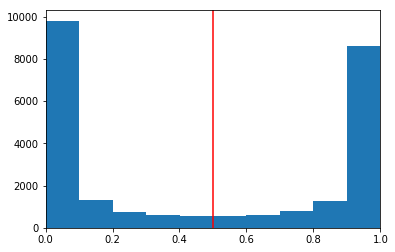

In [35]:
display_class_seperation(model)

# GRU using the Sequential API

In [36]:
model = Sequential(name="gru_sequential")
model.add(Embedding(n_top_freq_words, 
                    embedding_dim, 
                    input_length=max_review_length, 
                    name="embedding_layer")) 
model.add(GRU(units=embedding_dim, name="lstm_layer"))
model.add(Dense(1, activation='sigmoid', name="dense_layer"))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, None, 64)          640000    
_________________________________________________________________
lstm_layer (GRU)             (None, 64)                24768     
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 65        
Total params: 664,833
Trainable params: 664,833
Non-trainable params: 0
_________________________________________________________________


In [37]:
display_model(model)

In [38]:
train_and_eval(model, input_train, y_train, input_test, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 20s 993us/step - loss: 0.4873 - acc: 0.7470 - val_loss: 0.3651 - val_acc: 0.8384
Epoch 2/4
20000/20000 [==============================] - 19s 961us/step - loss: 0.2712 - acc: 0.8899 - val_loss: 0.3557 - val_acc: 0.8464
Epoch 3/4
20000/20000 [==============================] - 19s 965us/step - loss: 0.2101 - acc: 0.9189 - val_loss: 0.3809 - val_acc: 0.8322
Epoch 4/4
25000/25000 [==============================] - 11s 422us/step
Test score: 0.49877956864833833
Test accuracy: 0.82116


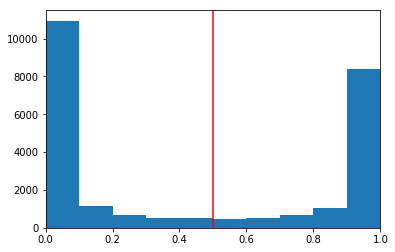

In [39]:
display_class_seperation(model)